In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 
'''

import numpy as np
import matplotlib.pyplot as plt
import time

from functools import partial

from qiskit.circuit.library import EfficientSU2

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.algorithms.optimizers import SLSQP, COBYLA

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from collections import Counter

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

from modified_derandomization import modified_derandomized_classical_shadow





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86



# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


-0.8105479805373264 * IIII
+ 0.17218393261915543 * IIIZ
- 0.22575349222402474 * IIZZ
+ 0.1209126326177664 * IIZI
+ 0.1721839326191556 * IZII
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
- 0.22575349222402485 * ZZZI
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [39]:
'''
Use classical eigensolver to obtain the ground state energy for the molecule of interest. 
This value is ca. -1.86 and will be used for evaluating the accuracy of the results found by the quantum-classical method.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy found using classical eigensolver:\n', res) 

Electronic ground state energy found using classical eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties. 
This includes removing all Pauli-I operators.
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print('All Hamiltonian terms:\n', hamiltonian_terms)
print('All weights:\n', weights)




hamiltonian_terms_XYZ = []

for term in hamiltonian_terms:
    term_XYZ = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZ.append(pauli)
    hamiltonian_terms_XYZ.append(term_XYZ)   
    
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZ)

All Hamiltonian terms:
 [[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
All weights:
 [-0.8105479805373264, 0.17218393261915543, -0.22575349222402474, 0.1209126326177664, 0.1721839326191556, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, -0.22575349222402485, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
Hamiltonian terms

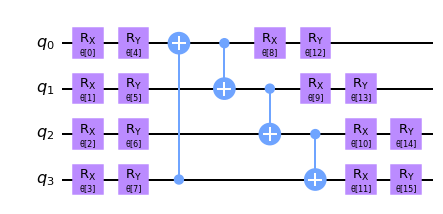

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [4]:
'''
Define the cost function = the expectation value of the Hamiltonian H. 
Since the Hamiltonian is processed term by term, the expectation value is composed as follows:
expval(H) = sum_i (weight_i * expval(term_i))
'''


backend = QasmSimulator(method='statevector', shots=1)


# generate a circuit with just a single layer of randomised basis change operators
# this circuit is appended to the ansatz and then measurements are taken in the Pauli-Z basis
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas



def objective_function(operators, params):
    
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in operators)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    # NOTE: For term = [] we have that sum_product = match_count = len(shadow)
    
    cost = 0.0

    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)     
        
    cost_history.append(cost)

        
    return cost


In [5]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510 for the size of 1000 operators. 
'''



start_time = time.time()

print('NUMBER OF OPERATORS - OPERATORS - AVERAGE ERROR')

measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:    

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)


    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        #print("GROUND STATE ENERGY FOUND = ", min(cost_history))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('{} - {} - {}'.format(num_operators, counts, rmse_derandomised_cs))
    print('EXPECTATION VALUES ', *expectation_values)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUMBER OF OPERATORS - OPERATORS - AVERAGE ERROR
1 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
EXPECTATION VALUES  -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842 -0.8557807804833842
250 - Counter({('X', 'X', 'X', 'X'): 196, ('Z', 'Z', 'Z', 'Z'): 41, ('Z', 'X', 'X', 'X'): 6, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'Z', 'X', 'Z'): 2}) - 0.7289183098085832
EXPECTATION VALUES  -1.1782332965862559 -1.0482969047723736 -1.2047613369241237 -1.189156000484052 -1.2062887941528535 -1.0436505709122454 -1.1984250269946475 -1.2239757813134216 -0.8826494000293821 -1.2127019883914507
500 - Counter({('X', 'X', 'X', 'X'): 391, ('Z', 'Z', 'Z', 'Z'): 83, ('Z', 'X', 'X', 'X'): 17, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'Z', 'X', 'Z'): 4}) - 0.6850971209570934
EXPECTATION VALUES  -1.1897376775455706 -1.0076891813161533 -1.2255060595121636 -1.029696132933334 -1.1496995452301622 -1.2

In [5]:
'''
Experiments with varying num_obs_evals. 
We test if more heterogeneous derandomized Hamiltonian performs better than more homogeneous one.
'''

    
start_time = time.time()

print('NUMBER OF EVALUATIONS PER OBSERVABLE - OPERATORS - AVERAGE ERROR')


for num_evals in range(1, 101):    

    derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_evals, system_size, weight=weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)


    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))    



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('{} - {} - {}'.format(num_evals, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



NUMBER OF EVALUATIONS PER OBSERVABLE - OPERATORS - AVERAGE ERROR
1 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
2 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
3 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
4 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
5 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
6 - Counter({('Z', 'Z', 'X', 'Z'): 1}) - 0.6993682622422372
7 - Counter({('Z', 'Z', 'Z', 'Z'): 1}) - 0.2707502201289882
8 - Counter({('Z', 'Z', 'Z', 'Z'): 1}) - 0.023032008797015724
9 - Counter({('Z', 'Z', 'Z', 'Z'): 1}) - 0.023032008797015724
10 - Counter({('Z', 'Z', 'Z', 'Z'): 1}) - 0.023032008797015724
11 - Counter({('Z', 'Z', 'Z', 'Z'): 1}) - 0.023032008797015724
12 - Counter({('Z', 'Z', 'Z', 'Z'): 1, ('Z', 'Z', 'X', 'Z'): 1}) - 0.1974723809642618
13 - Counter({('Z', 'Z', 'Z', 'Z'): 2}) - 0.2655701376737512
14 - Counter({('Z', 'Z', 'Z', 'Z'): 2}) - 0.2685466461990888
15 - Counter({('Z', 'Z', 'Z', 'Z'): 2}) - 0.28111684384492125


85 - Counter({('Z', 'Z', 'Z', 'Z'): 14, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 1}) - 0.5999731961644862
86 - Counter({('Z', 'Z', 'Z', 'Z'): 14, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1}) - 0.5546911726947943
87 - Counter({('Z', 'Z', 'Z', 'Z'): 14, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1}) - 0.5662566442094205
88 - Counter({('Z', 'Z', 'Z', 'Z'): 14, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1}) - 0.6268106244628437
89 - Counter({('Z', 'Z', 'Z', 'Z'): 14, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 2, ('Z', 'Z', 'X', 'Z'): 1}) - 0.5919903051652526
90 - Counter({('Z', 'Z', 'Z', 'Z'): 14, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 2, ('Z', 'Z', 'X', 'Z'): 1}) - 0.5425676471566379
91 - Counter({('Z', 'Z', 'Z', 'Z'): 15, ('Z', 'X', 'Z', 'X'): 3, ('Z', 'X', 'X', 'X'): 1}) - 0.5832363880127329
92 - Counter({('Z', 'Z', 'Z', 'Z'): 15, ('Z', 'X', 'Z', 'X'): 3, ('Z', 'X', 'X', 'X'): 1, (